<a href="https://colab.research.google.com/github/willamydias/mestrado/blob/main/3_2_3_Com_CAT_Lazzyregression_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# incializando ambiente

In [ ]:
%%time
import os
os.environ['USE_PYGEOS'] = '0'
import plotly.express as px
import IPython
from IPython.display import display, HTML

import locale

# Definir o ponto como separador de números
#locale.setlocale(locale.LC_NUMERIC, 'en_US.UTF-8')
locale.setlocale(locale.LC_ALL, "Portuguese_Brazil.1252")
# Definir o locale para o formato brasileiro (pt_BR)

# Função para formatar os números com ponto como separador de milhar e vírgula como separador decimal
def formatar_numero(valor):
    return '{:,.3f}'.format(valor)

# Registrar a função de formatação para uso global em saídas
display(HTML('<style>.output {font-size: 14px;}</style>'))  # Apenas para ajustar o tamanho da fonte
display(HTML('<script>var formatarNumero = {};</script>'.format(formatar_numero)))


import scipy as sp
#import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.formatter.use_locale'] = True

import warnings
import re
warnings.filterwarnings('ignore')
pd.set_option("display.precision", 2)
pd.set_option("display.float_format", '{:,.3f}'.format)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 50)
pd.options.display.min_rows = 115
label = 'valor_oferta'

from lazypredict.Supervised import LazyRegressor
from sklearn import datasets
from sklearn.base import RegressorMixin
from sklearn.utils import (shuffle,
                           all_estimators)

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.experimental import (enable_hist_gradient_boosting,
                                  enable_halving_search_cv )

from sklearn.model_selection import (HalvingRandomSearchCV,
                                     cross_val_score,
                                     cross_val_predict,
                                     RandomizedSearchCV,
                                     cross_validate,
                                     train_test_split,
                                     GridSearchCV)

from sklearn.metrics import (RocCurveDisplay,
                             r2_score,
                             mean_absolute_error,
                             mean_squared_error,
                             PredictionErrorDisplay,
                             explained_variance_score)

from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline

import xgboost
import lightgbm

from sklearn.preprocessing import (LabelEncoder,
                                   OrdinalEncoder,
                                   OneHotEncoder,
                                   MinMaxScaler,
                                   minmax_scale,
                                   MaxAbsScaler,
                                   StandardScaler,
                                   RobustScaler,
                                   Normalizer,
                                   QuantileTransformer,
                                   PowerTransformer)
# %matplotlib inline
import statsmodels.api as sm

from yellowbrick.features import FeatureImportances, JointPlotVisualizer
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC
from yellowbrick.regressor import AlphaSelection, CooksDistance, ManualAlphaSelection, ResidualsPlot, PredictionError
from yellowbrick.datasets import load_concrete


%autosave 120

Autosaving every 120 seconds
CPU times: total: 3.39 s
Wall time: 3.66 s


## Carregando banco de dados

In [ ]:
%%time
# import data
df = pd.read_csv('gdf_final - gdf_final_ultimo.csv',  # gdf_clean_1_4_2023.csv  gdf_final.csv
                encoding = 'ANSI', sep=';' , decimal=',' ) #'utf-8'

#############
#df['R$_por_m2'] = df ['valor_oferta'] / df ['area'] / R$_por_m2
#df_sem_duplicatas = df.drop_duplicates(subset=['valor_ponderado', 'area',
                                               #'ra','setor', 'data_condicao', 'vend_data_data'])

df['valor_oferta'] = df['valor_ponderado']

del df['R$_por_m2'] , df['data_condicao'] , df['valor_ponderado'] , df['area_acumulada'], df['setor_distancia']

# alta correlação <----------------------------------------------------------------------
del df['valor_taxa_impermeabilidade'] , df['distancia_de_400_metros_maisperto'] , df['mobiliario_esporte_e_lazer_contagem']

#del df['index_atualizacao']
#df['valor_oferta'].describe()
# df['valor_ponderado'].describe()

cat_cols = df.select_dtypes(include=['category', 'string', 'object']).columns.to_list()

cat_cols_num = []
# Loop para iterar sobre as colunas do DataFrame
for coluna in df.select_dtypes(exclude=['category', 'string', 'object']).columns:
    # Verificar se a coluna possui menos de 20 valores únicos
    if df[coluna].nunique() < 30:
        # Transformar a coluna em tipo categórico
        #print(coluna, df[coluna].nunique())
        df[coluna] = df[coluna].astype('category')
        cat_cols.append(coluna)
        cat_cols_num.append(coluna)

CPU times: total: 156 ms
Wall time: 155 ms


### dados categoricos

In [ ]:
%%time
for cols in cat_cols:
    print(cols, len(df[cols].unique()))

ra 19
setor 164
situacao 8
tipologia 40
destinacao 192
index_atualizacao 237
vendido_em_grupo 2
ref_referencia 3
pos_posicao 3
linhas_de_transportes_de_alta_densidade_contagem 13
mapa_1c_unidades_de_planejamento_territorial_contagem 4
mapa_1c_unidades_de_planejamento_territorial_maisperto 6
area_tombada_contagem 2
regioes_administrativas_maisperto 23
rede_estrutural_de_transporte_coletivo_contagem 20
regulaziracao_contagem 5
diretrizes_urbanisticas_contagem 7
CPU times: total: 15.6 ms
Wall time: 15 ms


Apresentado dados davariável

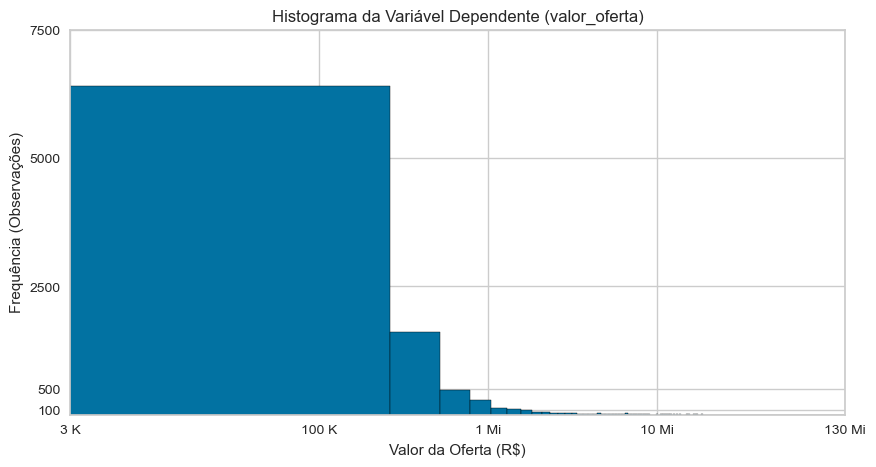

In [ ]:
#import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Função para formatar os números em milhares com o sufixo 'k'
def formatar_milhares(x, pos):
    if x >= 1000000:
        return f'{x/1000000:.0f} Mi'
    return f'{x/1000:.0f} K'

# Definir a função de formatação para o eixo y
#formatter = mticker.FuncFormatter(formatar_milhares)
#plt.gca().xaxis.set_major_formatter(formatter)
plt.figure(figsize=(10, 5))
# Criar o histograma
n, bins, patches = plt.hist(df['valor_oferta'], bins=500, edgecolor='black')  # O número de bins pode ser ajustado conforme necessário
#plt.hist(df['valor_oferta'],  bins=1000,edgecolor='black')  # bins=50, O número de bins pode ser ajustado conforme necessário

plt.xlim(df['valor_oferta'].min(), df['valor_oferta'].max())

# Adicionar rótulos e título
plt.xlabel('Valor da Oferta (R$)')
plt.ylabel('Frequência (Observações)')
plt.title('Histograma da Variável Dependente (valor_oferta)')

# Definir o eixo x em escala logarítmica
plt.yscale('linear')
plt.xscale('log')

# Definir os rótulos do eixo x em potências de 10 (ou outros valores desejados)
potencias = [100, 500, 2500, 5000, 7500]  # Exemplo de potências de 10 como rótulos do eixo x
plt.yticks(potencias, [f'{p}' for p in potencias])

# Definir os rótulos do eixo x em potências de 10 (ou outros valores desejados)
potencias = [ df['valor_oferta'].min()-1, 100000, 1000000, 10000000,  df['valor_oferta'].max()+1]  # Exemplo de potências de 10 como rótulos do eixo x
plt.xticks(potencias , [f'{formatar_milhares(int(p),1)}' for p in potencias]) #[f'1{int(np.log10(p))}' for p in potencias]

# Adicionar a contagem dos valores no gráfico
#for count, x, patch in zip(n, bins[:-1], patches):
#    height = patch.get_height()
#    plt.text(x + (bins[1] - bins[0]) / 2, height, f'{int(count)}', ha='center', va='bottom')


# Exibir o gráfico
plt.show()

In [ ]:
df['valor_oferta'].describe()


count        9959.00
mean       916170.68
std       3237944.42
min          3375.00
25%         79601.00
50%        176670.00
75%        405058.50
max     129670000.00
Name: valor_oferta, dtype: float64

In [ ]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
vendido_em_grupo,9959.00,2.00,0.00,8541.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
valor_oferta,9959.00,NaN,NaN,NaN,916170.68,3237944.42,3375.00,79601.00,176670.00,405058.50,129670000.00
area,9959.00,NaN,NaN,NaN,716.89,1929.16,4.00,128.20,300.00,822.00,75471.50
area_max,9959.00,NaN,NaN,NaN,1779.72,4496.62,4.00,315.00,640.00,1469.43,181131.60
ra,9959,19,Samambaia,2987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
setor,9959,164,QS-SAMAMBAIA (SAMAMBAIA),1284,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max_condicao,9959.00,NaN,NaN,NaN,43.78,39.25,4.00,17.00,33.00,55.00,403.00
situacao,9959,8,1 - VAGO,6475,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tipologia,9959,40,60217,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
destinacao,9959,192,"60217 - UOS CSIIR 2 - COMERCIAL, PRESTA€ÇO DE ...",1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dividindo dataframe
(Variáveis independentes X e dependentes Y)

In [ ]:
%%time
X = df.drop("valor_oferta", axis=1)

X_trans = df.drop("valor_oferta", axis=1)


#
### transformações em Y
#

y_1 = df["valor_oferta"]
y_2 = df["valor_oferta"] / df["area"]
y_3 = np.log(df["valor_oferta"] / df["area"])
y_4 = np.log(df["valor_oferta"])
y_5 = 1 / np.sqrt(df["valor_oferta"])


#X = X.drop(cat_cols, axis=1)
#X.columns

#
# transformações em X
#
def custom_transformation(valor_original):
    transformed_valor_original= 1 / (valor_original ** 2)
    return transformed_valor_original

X_trans['area'] = np.log(X_trans['area'])
X_trans['tipologia'] = np.log(X_trans['tipologia'])


y_1.name = "Valor_Oferta"
y_2.name = "Valor_Oferta/area"
y_3.name = "log(Valor_Oferta/area)"
y_4.name = "log(Valor_Oferta)"
y_5.name = "1/Valor_Oferta¹/²"

TypeError: loop of ufunc does not support argument 0 of type str which has no callable log method

<Axes: xlabel='valor_oferta', ylabel='ra'>

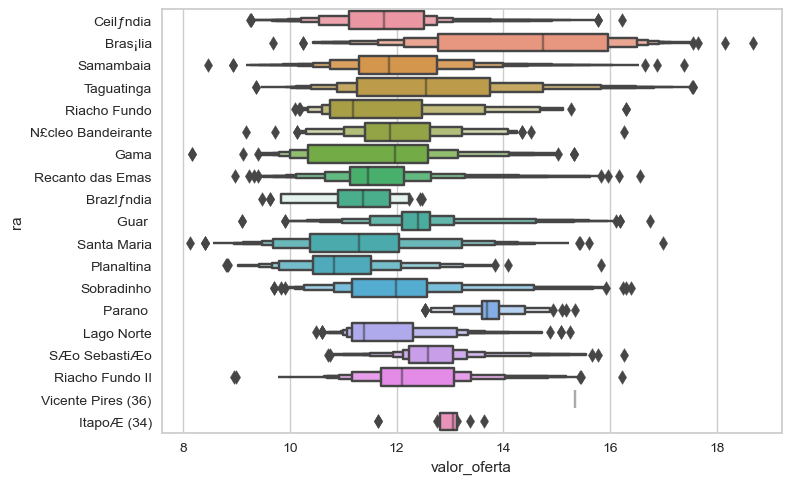

In [ ]:
sns.boxenplot(x=y_4, y=df['ra'], k_depth="trustworthy",
              scale="exponential")

### Tratamento

In [ ]:
%%time
#############################################
# TRATAMENTO DAS VARIÁVEIS CATEGÓRICAS
# ra 19 / setor 199 / condicao 43 / situacao 8 / tipologia 43 / destinacao 287
#############################################
preprocessor  = ColumnTransformer([("cat_",
#         OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
         OrdinalEncoder(dtype=np.int64),
         cat_cols),],).set_output(transform="pandas")

#melhor_regressor_one_hot = make_pipeline(
#    one_hot_encoder, HistGradientBoostingRegressor(**melhor_parametro, random_state=42)
#)

X[cat_cols] = preprocessor.fit_transform(X)
#X[cat_cols]

CPU times: total: 46.9 ms
Wall time: 50 ms


## Selecionando regressores
utilizando biblioteca lazzyregressor

In [ ]:
%%time
all_estimators()
removed_regressors = [
    "TheilSenRegressor",
    "ARDRegression",
    "CCA",
    "IsotonicRegression",
    "StackingRegressor",
    "MultiOutputRegressor",
    "MultiTaskElasticNet",
    "MultiTaskElasticNetCV",
    "MultiTaskLasso",
    "MultiTaskLassoCV",
    "PLSCanonical",
    "PLSRegression",
    "RadiusNeighborsRegressor",
    "RegressorChain",
    "VotingRegressor",
    #adicionado por custo temporal
    "RandomForestRegressor",
    "QuantileRegressor",
]

REGRESSORS = [
    est
    for est in all_estimators()
    if (issubclass(est[1], RegressorMixin) and (est[0] not in removed_regressors))
]

#(n_estimators=1000, learning_rate=0.05, n_jobs=4)
REGRESSORS.append(("XGBRegressor", xgboost.XGBRegressor))
#(task = 'train',   objective= 'regression', subsample= 0.8, max_depth=7, learning_rate= 0.1)
REGRESSORS.append(("LGBMRegressor", lightgbm.LGBMRegressor ))



#regressors=
#REGRESSORS

CPU times: total: 141 ms
Wall time: 145 ms


In [ ]:
%%time
print(y_1.name)

#X_train, X_test, y_train, y_test = train_test_split(X, y_1, test_size=0.25, random_state=0)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y_1, test_size=0.3, random_state=42)


reg_1 = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None, predictions=True , regressors=REGRESSORS)

models_1, predictions_1 = reg_1.fit(X_train_1, X_test_1, y_train_1, y_test_1)

model_dictionary_1= reg_1.provide_models(X_train_1, X_test_1, y_train_1, y_test_1)


models_1[models_1['R-Squared']>=0.7]

#models[models['R-Squared']>=0.4]
models_1 = models_1.reset_index().rename(columns={'index': 'Index'})
models_1['y']=y_1.name
models_1['frame']='models_1'


valor_oferta
'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:02<00:00,  1.55s/it]

CPU times: total: 7min 5s
Wall time: 1min 2s


In [ ]:
%%time
print(y_2.name)

#X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.25, random_state=0)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y_2, test_size=0.3, random_state=42)


reg_2 = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None, predictions=True , regressors=REGRESSORS)

models_2, predictions_2 = reg_2.fit(X_train_2, X_test_2, y_train_2, y_test_2)

model_dictionary_2= reg_2.provide_models(X_train_2, X_test_2, y_train_2, y_test_2)

models_2[models_2['R-Squared']>=0.7]

#models[models['R-Squared']>=0.4]
models_2 = models_2.reset_index().rename(columns={'index': 'Index'})
models_2['y']=y_2.name
models_2['frame']='models_2'


None
'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:01<00:00,  1.53s/it]

CPU times: total: 7min 40s
Wall time: 1min 1s


In [ ]:
%%time
print(y_3.name)

#X_train, X_test, y_train, y_test = train_test_split(X, y3, test_size=0.25, random_state=0)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y_3, test_size=0.3, random_state=42)


reg_3 = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None, predictions=True , regressors=REGRESSORS)

models_3, predictions_3 = reg_3.fit(X_train_3, X_test_3, y_train_3, y_test_3 )

model_dictionary_3= reg_3.provide_models(X_train_3, X_test_3, y_train_3, y_test_3 )

models_3[models_3['R-Squared']>=0.7]

#models[models['R-Squared']>=0.4]
models_3 = models_3.reset_index().rename(columns={'index': 'Index'})
models_3['y']=y_3.name
models_3['frame']='models_3'

None
'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:58<00:00,  1.46s/it]

CPU times: total: 6min 49s
Wall time: 58.4 s


In [ ]:
%%time
print(y_4.name)

#X_train, X_test, y_train, y_test = train_test_split(X, y3, test_size=0.25, random_state=0)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, y_4, test_size=0.3, random_state=42)


reg_4 = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None, predictions=True , regressors=REGRESSORS)

models_4, predictions_4 = reg_3.fit(X_train_4, X_test_4, y_train_4, y_test_4 )

model_dictionary_4= reg_4.provide_models(X_train_4, X_test_4, y_train_4, y_test_4 )

models_4[models_4['R-Squared']>=0.7]

#models[models['R-Squared']>=0.4]
models_4 = models_4.reset_index().rename(columns={'index': 'Index'})
models_4['y']=y_4.name
models_4['frame']='models_4'

valor_oferta
'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:00<00:00,  1.52s/it]


'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:59<00:00,  1.48s/it]

CPU times: total: 14min 29s
Wall time: 2min


In [ ]:
%%time
print(y_5.name)

#X_train, X_test, y_train, y_test = train_test_split(X, y3, test_size=0.25, random_state=0)
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X, y_5, test_size=0.3, random_state=42)


reg_5 = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None, predictions=True , regressors=REGRESSORS)

models_5, predictions_5 = reg_3.fit(X_train_5, X_test_5, y_train_5, y_test_5)

model_dictionary_5= reg_5.provide_models(X_train_5, X_test_5, y_train_5, y_test_5 )

models_5[models_5['R-Squared']>=0.7]

#models[models['R-Squared']>=0.4]
models_5 = models_5.reset_index().rename(columns={'index': 'Index'})
models_5['y']=y_5.name
models_5['frame']='models_5'

valor_oferta
'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:08<00:00,  1.72s/it]


'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:09<00:00,  1.73s/it]

CPU times: total: 10min 46s
Wall time: 2min 18s


In [ ]:

models_all = models_1.merge(models_2, how='outer')
models_all = models_all.merge(models_3, how='outer')
models_all = models_all.merge(models_4, how='outer')
models_all = models_all.merge(models_5, how='outer')

In [ ]:
models_all = models_all.sort_values('R-Squared', ascending=False)
models_all[models_all['R-Squared']>=0.75]

,Model,Adjusted R-Squared,R-Squared,RMSE,Time Taken,y,frame
120,LGBMRegressor,0.92,0.92,0.39,0.43,valor_oferta,models_4
121,HistGradientBoostingRegressor,0.92,0.92,0.40,1.86,valor_oferta,models_4
122,XGBRegressor,0.92,0.92,0.40,0.68,valor_oferta,models_4
123,ExtraTreesRegressor,0.91,0.91,0.42,13.37,valor_oferta,models_4
124,BaggingRegressor,0.90,0.90,0.45,2.52,valor_oferta,models_4
125,GradientBoostingRegressor,0.90,0.90,0.45,3.41,valor_oferta,models_4
126,SVR,0.87,0.87,0.52,6.54,valor_oferta,models_4
127,NuSVR,0.87,0.87,0.52,6.29,valor_oferta,models_4
80,HistGradientBoostingRegressor,0.86,0.86,0.39,1.60,None,models_3
128,MLPRegressor,0.86,0.86,0.53,6.51,valor_oferta,models_4


In [ ]:
#models_all[models_all['frame']=='models_1'].head(1)
# Use a função groupby para agrupar os dados pela coluna YY e em seguida, use a função idxmax() para encontrar o índice do maior valor de XX para cada categoria de YY
idx = models_all.groupby('frame')['Adjusted R-Squared'].idxmax()

# Use a função loc() para acessar o valor correspondente na coluna BB
max_modelos = models_all.loc[idx, ['Model', 'frame', 'Adjusted R-Squared']]

max_mod_1 = max_modelos.iloc[0]['Model']
max_mod_2 = max_modelos.iloc[1]['Model']
max_mod_3 = max_modelos.iloc[2]['Model']
max_mod_4 = max_modelos.iloc[3]['Model']
max_mod_5 = max_modelos.iloc[4]['Model']

max_modelos

,Model,frame,Adjusted R-Squared
0,LGBMRegressor,models_1,0.82
40,XGBRegressor,models_2,0.69
80,HistGradientBoostingRegressor,models_3,0.86
120,LGBMRegressor,models_4,0.92
160,HistGradientBoostingRegressor,models_5,0.84


In [ ]:
modelo_1=reg_1.models.get(max_mod_1 )
modelo_2=reg_2.models.get(max_mod_2 )
modelo_3=reg_3.models.get(max_mod_3 )
modelo_4=reg_4.models.get(max_mod_4 )
modelo_5=reg_5.models.get(max_mod_5 )

y_pred1 = cross_val_predict(modelo_1, X, y_1, cv=10)
y_pred2 = cross_val_predict(modelo_2, X, y_2, cv=10)
y_pred3 = cross_val_predict(modelo_3, X, y_3, cv=10)
y_pred4 = cross_val_predict(modelo_4, X, y_4, cv=10)
y_pred5 = cross_val_predict(modelo_5, X, y_5, cv=10)


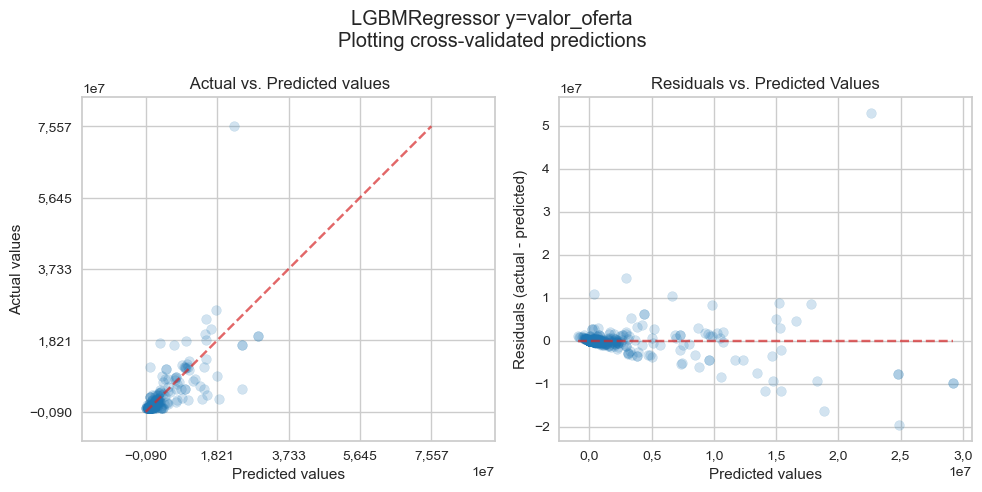

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

_ = PredictionErrorDisplay.from_predictions(y_1, y_pred=y_pred1 , kind='actual_vs_predicted', ax=axs[0],  random_state=0,
                                           scatter_kwargs={"alpha": 0.2, "color": "tab:blue"}, line_kwargs={"color": "tab:red"})
_ = PredictionErrorDisplay.from_predictions(y_1, y_pred=y_pred1 , kind='residual_vs_predicted', ax=axs[1],  random_state=0,
                                           scatter_kwargs={"alpha": 0.2, "color": "tab:blue"}, line_kwargs={"color": "tab:red"})
axs[0].set_title(" Actual vs. Predicted values")
axs[1].set_title("Residuals vs. Predicted Values")

fig.suptitle(f"{max_mod_1} y={y_1.name}\nPlotting cross-validated predictions")
plt.tight_layout()
plt.show()

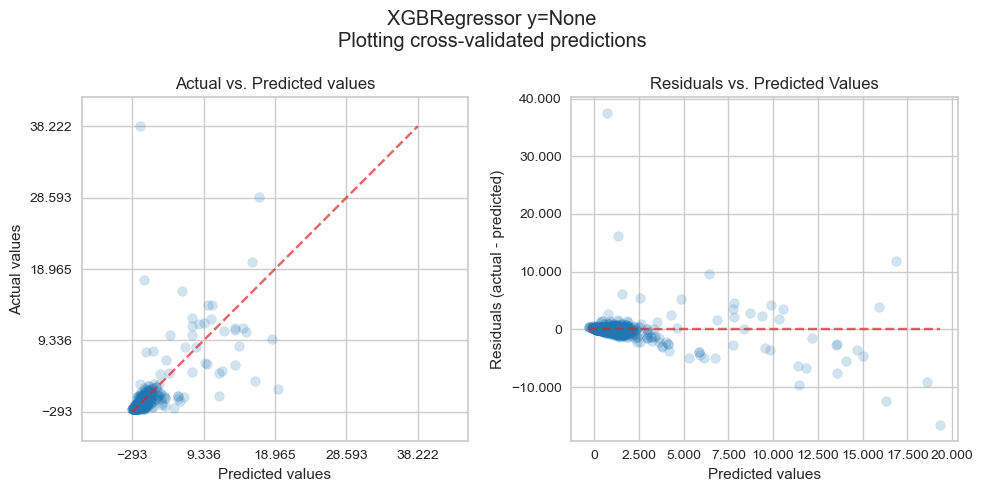

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
_ = PredictionErrorDisplay.from_predictions(y_2, y_pred=y_pred2 , kind='actual_vs_predicted', ax=axs[0],  random_state=0,
                                           scatter_kwargs={"alpha": 0.2, "color": "tab:blue"}, line_kwargs={"color": "tab:red"})
_ = PredictionErrorDisplay.from_predictions(y_2, y_pred=y_pred2 , kind='residual_vs_predicted', ax=axs[1],  random_state=0,
                                           scatter_kwargs={"alpha": 0.2, "color": "tab:blue"}, line_kwargs={"color": "tab:red"})
axs[0].set_title("Actual vs. Predicted values")
axs[1].set_title("Residuals vs. Predicted Values")

fig.suptitle(f"{max_mod_2} y={y_2.name}\nPlotting cross-validated predictions")
plt.tight_layout()
plt.show()

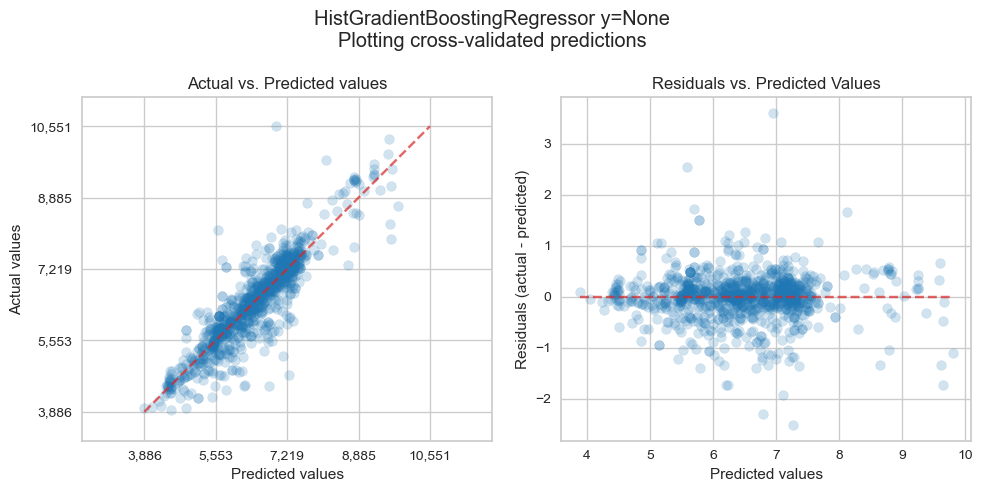

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
_ = PredictionErrorDisplay.from_predictions(y_3, y_pred=y_pred3 , kind='actual_vs_predicted', ax=axs[0],  random_state=0,
                                            scatter_kwargs={"alpha": 0.2, "color": "tab:blue"}, line_kwargs={"color": "tab:red"})
_ = PredictionErrorDisplay.from_predictions(y_3, y_pred=y_pred3 , kind='residual_vs_predicted', ax=axs[1],  random_state=0,
                                           scatter_kwargs={"alpha": 0.2, "color": "tab:blue"}, line_kwargs={"color": "tab:red"})
axs[0].set_title("Actual vs. Predicted values")
axs[1].set_title("Residuals vs. Predicted Values")

fig.suptitle(f"{max_mod_3} y={y_3.name}\nPlotting cross-validated predictions")
plt.tight_layout()
plt.show()

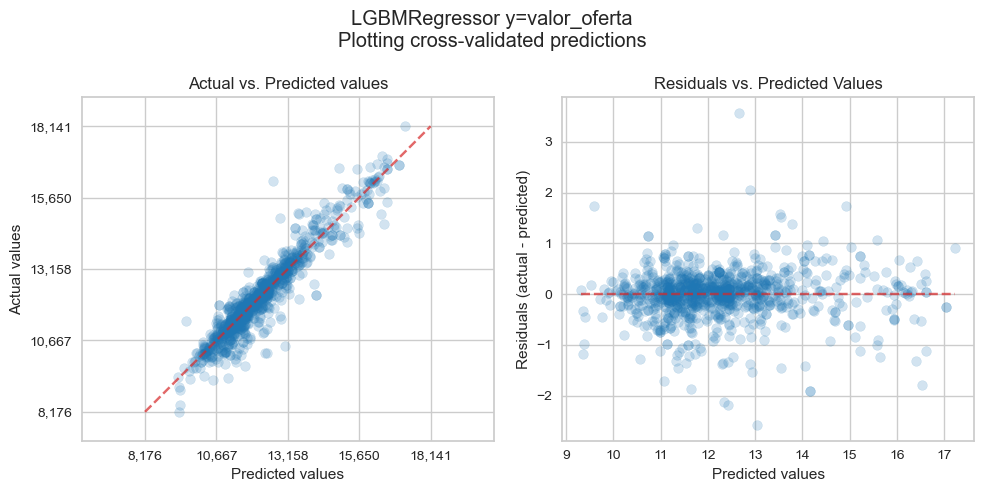

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
_ = PredictionErrorDisplay.from_predictions(y_4, y_pred=y_pred4 , kind='actual_vs_predicted', ax=axs[0],  random_state=0,
                                            scatter_kwargs={"alpha": 0.2, "color": "tab:blue"}, line_kwargs={"color": "tab:red"})
_ = PredictionErrorDisplay.from_predictions(y_4, y_pred=y_pred4 , kind='residual_vs_predicted', ax=axs[1],  random_state=0,
                                           scatter_kwargs={"alpha": 0.2, "color": "tab:blue"}, line_kwargs={"color": "tab:red"})
axs[0].set_title("Actual vs. Predicted values")
axs[1].set_title("Residuals vs. Predicted Values")

fig.suptitle(f"{max_mod_4} y={y_4.name}\nPlotting cross-validated predictions")
plt.tight_layout()
plt.show()

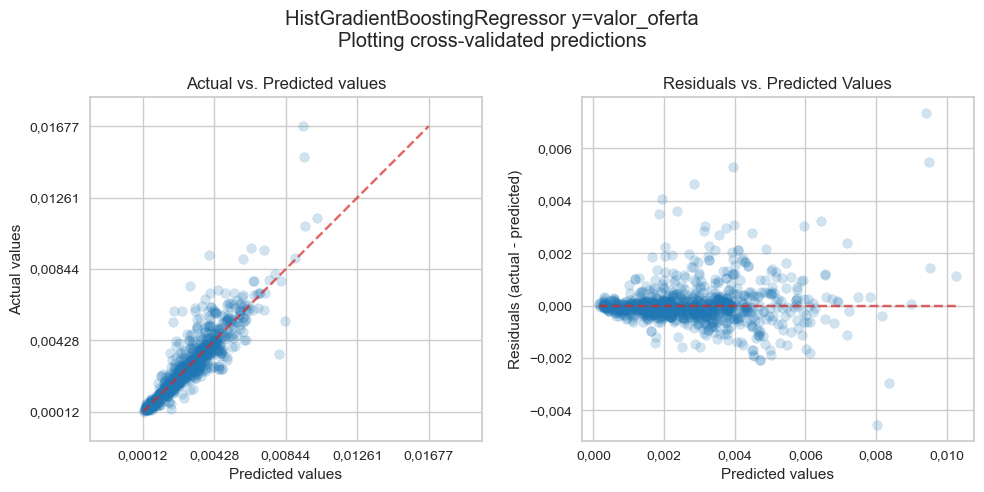

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
_ = PredictionErrorDisplay.from_predictions(y_5, y_pred=y_pred5 , kind='actual_vs_predicted', ax=axs[0],  random_state=0,
                                            scatter_kwargs={"alpha": 0.2, "color": "tab:blue"}, line_kwargs={"color": "tab:red"})
_ = PredictionErrorDisplay.from_predictions(y_5, y_pred=y_pred5 , kind='residual_vs_predicted', ax=axs[1],  random_state=0,
                                           scatter_kwargs={"alpha": 0.2, "color": "tab:blue"}, line_kwargs={"color": "tab:red"})
axs[0].set_title("Actual vs. Predicted values")
axs[1].set_title("Residuals vs. Predicted Values")

fig.suptitle(f"{max_mod_5} y={y_5.name}\nPlotting cross-validated predictions")
plt.tight_layout()
plt.show()

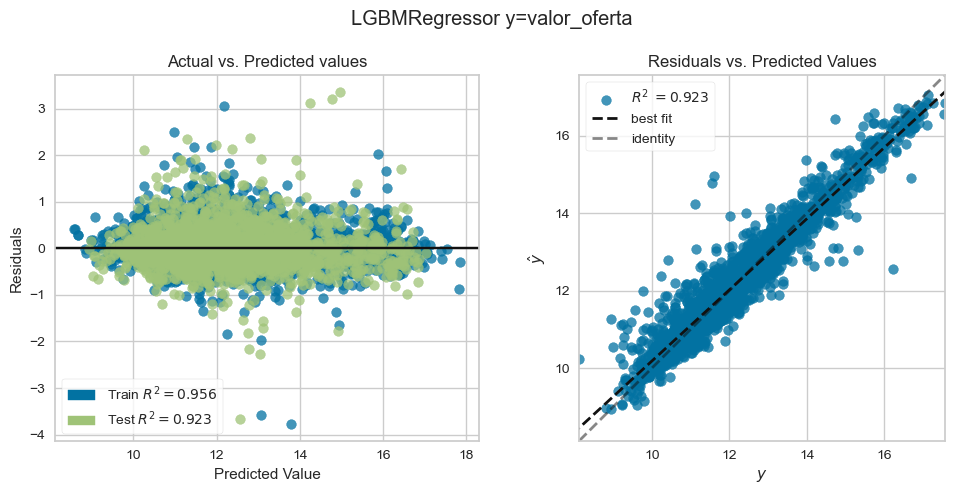

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
viz1 = ResidualsPlot( modelo_4, hist=False, ax=axs[0])
viz1.fit(X_train_4, y_train_4)
viz1.score(X_test_4, y_test_4)
viz1.finalize()

viz2 = PredictionError(modelo_4,  ax=axs[1] )
viz2.fit(X_train_4, y_train_4)
viz2.score(X_test_4, y_test_4)
viz2.finalize()

axs[0].set_title("Actual vs. Predicted values")
axs[1].set_title("Residuals vs. Predicted Values")

fig.suptitle(f"{max_mod_4} y={y_4.name}")
plt.tight_layout()
plt.show()

In [ ]:
# Suponha que você tenha os valores reais y_test
y_pred = modelo_4.predict(X_test_4)
mae = mean_absolute_error(y_test_4, y_pred)
mse = mean_squared_error(y_test_4, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_4, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-squared:", r2)

MAE: 0.25690718752321734
MSE: 0.1548747308418904
RMSE: 0.3935412695536396
R-squared: 0.9233950817849332


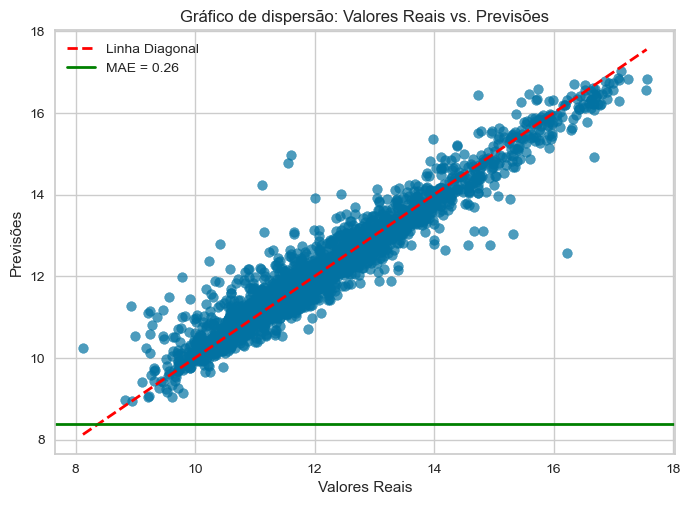

In [ ]:
# Gráfico de dispersão com a linha horizontal para o MAE
plt.scatter(y_test_4, y_pred, alpha=0.7)
plt.plot([min(y_test_4), max(y_test_4)], [min(y_test_4), max(y_test_4)], color='red', linestyle='--', linewidth=2, label='Linha Diagonal')
plt.axhline(y=mae+min(y_test_4), color='green', linestyle='-', linewidth=2, label=f'MAE = {mae:.2f}')
plt.xlabel("Valores Reais")
plt.ylabel("Previsões")
plt.title("Gráfico de dispersão: Valores Reais vs. Previsões")
plt.legend()
plt.show()

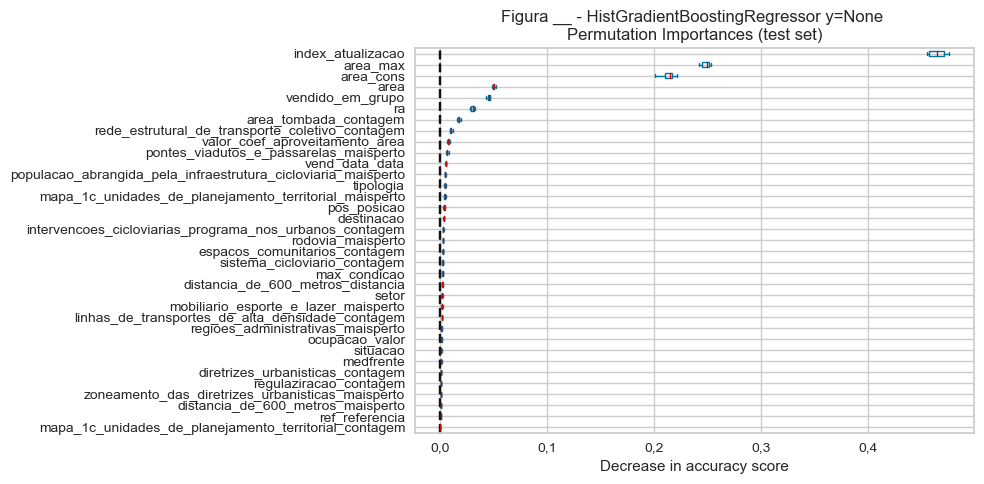

In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(modelo_4, X_test_4, y_test_4, n_repeats=10, random_state=42, n_jobs=2)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

ax = importances.plot.box(vert=False, whis=10, figsize=(10, 5))
#ax.set_title(f"{max_mod_3} y={y_3.name} \nPermutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")

ax.set_title(f"Figura __ - {max_mod_3} y={y_3.name} \nPermutation Importances (test set)", fontsize=12)

ax.figure.tight_layout()
plt.show()


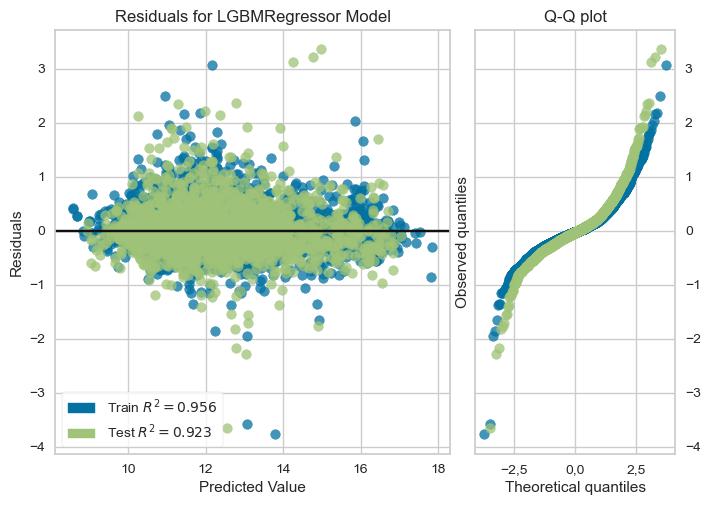

In [ ]:
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import PredictionError
#from yellowbrick.regressor.alphas import alphas
#from yellowbrick.regressor import cooks_distance

#modelo=reg.models.get('HistGradientBoostingRegressor')

viz = residuals_plot(modelo_4, X_train_4, y_train_4, X_test_4, y_test_4, hist=False, qqplot=True)


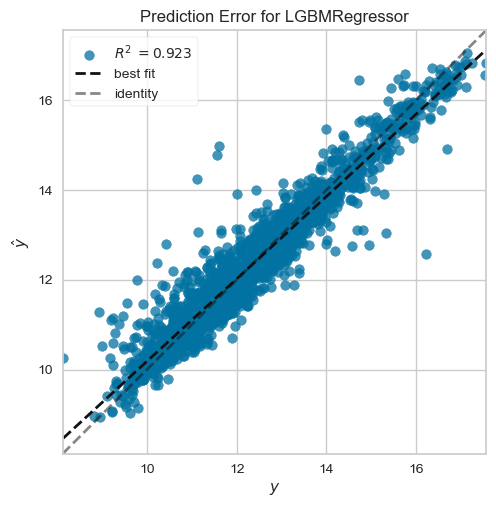

<Axes: title={'center': 'Prediction Error for LGBMRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [ ]:
from yellowbrick.regressor import PredictionError
visualizer = PredictionError(modelo_4)

visualizer.fit(X_train_4, y_train_4)  # Fit the training data to the visualizer
visualizer.score(X_test_4, y_test_4)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [ ]:
#model_OLS_1 = sm.OLS(y_1, X)
#model_OLS_2 = sm.OLS(y_2, X)
#model_OLS_3 = sm.OLS(y_3, X)
#model_OLS_4 = sm.OLS(y_4, X)
#model_OLS_5 = sm.OLS(y_5, X)

models = ['model_OLS_1', 'model_OLS_2', 'model_OLS_3', 'model_OLS_4', 'model_OLS_5' ]
y_s = [y_1, y_2, y_3, y_4, y_5]


In [ ]:
from sklearn.model_selection import KFold
# Número de folds para o cross-validation
n_folds = 5

# Inicialize o objeto KFold
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
# Listas para armazenar as métricas de desempenho
#mse_scores = []
#mae_scores = []
#rsquared_scores = []
results_df = pd.DataFrame()

for modelo, y_atual in zip (models, y_s):
    modelo_nome=modelo
    #X_train, X_test, y_train, y_test = train_test_split(X, y_atual, test_size=0.25, random_state=42)

    exec("modelo = sm.OLS(y_atual, X)")
    # Obtenha as previsões para os dados de treinamento
    #y_train_pred = modelo.predict(X_train)

    # Listas para armazenar as métricas de desempenho
    mse_scores = []
    mae_scores = []
    rsquared_scores = []

    # Loop para realizar o cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_atual.iloc[train_index], y_atual.iloc[test_index]
        # Adicione uma constante ao conjunto de dados X_train e X_test (intercepto)
        #X_train = sm.add_constant(X_train)
        #X_test = sm.add_constant(X_test)

        # Crie o modelo OLS e ajuste-o aos dados de treinamento
        model = sm.OLS(y_train, X_train)
        results = model.fit()

        # Obtenha as previsões para os dados de teste
        y_pred = results.predict(X_test)

        # Calcule as métricas de avaliação do modelo
        mse = np.mean((y_test - y_pred) ** 2)
        mae = np.mean(np.abs(y_test - y_pred))
        rsquared = results.rsquared

    # Armazene as métricas para cada fold
    mse_scores.append(mse)
    mae_scores.append(mae)
    rsquared_scores.append(rsquared)

    # Calcule as médias das métricas de desempenho para todos os folds
    mean_mse = np.mean(mse_scores)
    mean_mae = np.mean(mae_scores)
    mean_rsquared = np.mean(rsquared_scores)

    # Crie um DataFrame com as métricas do modelo
    metrics_dict = {
        'Modelo': modelo_nome,
        'R-squared': mean_rsquared,
        'MSE': mean_mse,
        'MAE': mean_mae,
    }

    results_df = results_df.append(metrics_dict, ignore_index=True)

print(results_df)


        Modelo  R-squared              MSE       MAE
0  model_OLS_1       0.61 4258930137441.78 918331.81
1  model_OLS_2       0.62     661110621.54   1563.55
2  model_OLS_3       0.99             0.46      0.50
3  model_OLS_4       0.99             1.13      0.82
4  model_OLS_5       0.85             0.00      0.00


In [ ]:
# Crie o modelo OLS e ajuste-o aos dados
modelo_OLS_4 = sm.OLS(y_4, X)
results = modelo_OLS_4.fit()

# Obtenha o resumo completo do modelo
summary = results.summary()

# Exiba o resumo
print(summary)

                                 OLS Regression Results                                
Dep. Variable:           valor_oferta   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          3.879e+04
Date:                qua, 26 jul 2023   Prob (F-statistic):                        0.00
Time:                        20:09:38   Log-Likelihood:                         -14620.
No. Observations:                9959   AIC:                                  2.931e+04
Df Residuals:                    9924   BIC:                                  2.956e+04
Df Model:                          35                                                  
Covariance Type:            nonrobust                                                  
                                                                    coef    std err          t      P>|t|      [0.025   

In [ ]:
# Adicione uma coluna constante para o termo do intercepto no modelo OLS
df['const'] = 1

# Etapa de backward elimination
# Escolha um nível de significância para decidir se uma variável deve ser removida ou não (por exemplo, 0.05)
significance_level = 0.05

while True:
    model = sm.OLS(y_5, X).fit()
    p_values = model.pvalues
    max_p_value = p_values.max()

    if max_p_value > significance_level:
        # Remove a variável com o maior valor p
        removed_variable = p_values.idxmax()
        X = X.drop(removed_variable, axis=1)
    else:
        # Todas as variáveis têm valores p menores ou iguais ao nível de significância
        break

print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:           valor_oferta   R-squared (uncentered):                   0.853
Model:                            OLS   Adj. R-squared (uncentered):              0.853
Method:                 Least Squares   F-statistic:                              1804.
Date:                qua, 26 jul 2023   Prob (F-statistic):                        0.00
Time:                        20:09:38   Log-Likelihood:                          52567.
No. Observations:                9959   AIC:                                 -1.051e+05
Df Residuals:                    9927   BIC:                                 -1.048e+05
Df Model:                          32                                                  
Covariance Type:            nonrobust                                                  
                                                                    coef    std err          t      P>|t|      [0.025   

In [ ]:
model.resid

0       0.00
1       0.00
2      -0.00
3       0.00
4      -0.00
5      -0.00
6       0.00
7       0.00
8      -0.00
9      -0.00
10      0.00
11     -0.00
12     -0.00
13      0.00
14      0.00
15      0.00
16      0.00
17      0.00
18      0.00
19      0.00
20      0.00
21     -0.00
22     -0.00
23     -0.00
24     -0.00
        ... 
9934    0.00
9935   -0.00
9936   -0.00
9937    0.00
9938   -0.00
9939   -0.00
9940   -0.00
9941   -0.00
9942   -0.00
9943   -0.00
9944   -0.00
9945   -0.00
9946   -0.00
9947   -0.00
9948   -0.00
9949    0.00
9950   -0.00
9951   -0.00
9952   -0.00
9953   -0.00
9954   -0.00
9955    0.00
9956    0.00
9957   -0.00
9958   -0.00
Length: 9959, dtype: float64

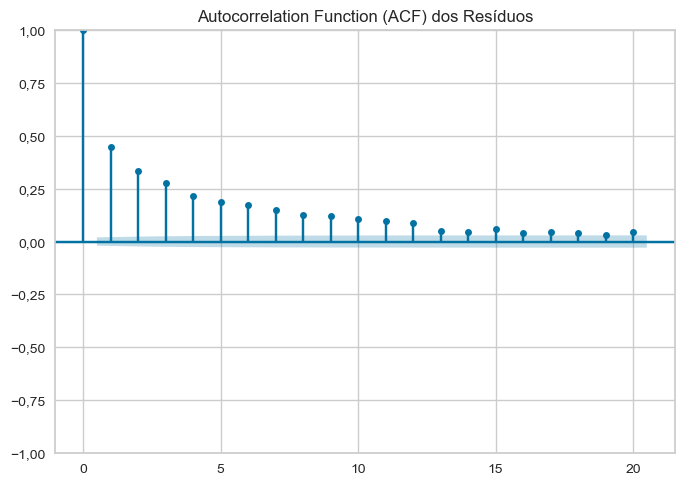

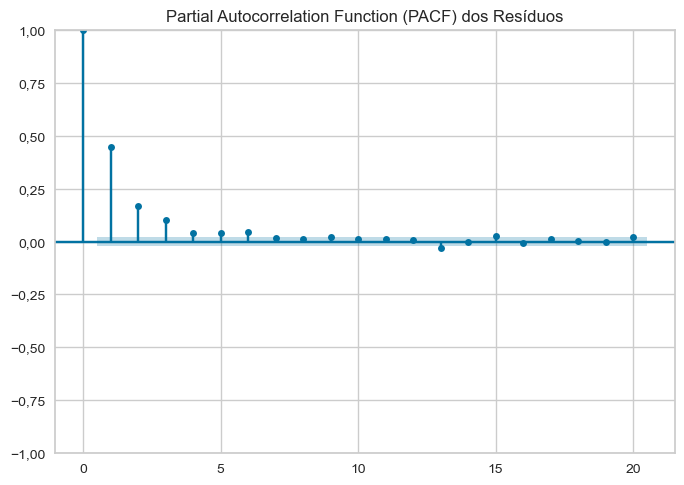

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Supondo que você já tenha ajustado o modelo e tenha os resíduos disponíveis
# modelo_fit é o resultado do modelo ajustado

# Extrair os resíduos do modelo ajustado
residuos = model.resid

# Plotar a ACF e a PACF dos resíduos para detectar autocorrelação
plot_acf(residuos, lags=20)
plt.title("Autocorrelation Function (ACF) dos Resíduos")
plt.show()

plot_pacf(residuos, lags=20)
plt.title("Partial Autocorrelation Function (PACF) dos Resíduos")
plt.show()

In [ ]:
model.bse

vendido_em_grupo                                                0.00
area                                                            0.00
area_max                                                        0.00
ra                                                              0.00
setor                                                           0.00
max_condicao                                                    0.00
situacao                                                        0.00
tipologia                                                       0.00
destinacao                                                      0.00
ref_referencia                                                  0.00
pos_posicao                                                     0.00
ocupacao_valor                                                  0.00
medfrente                                                       0.00
vend_data_data                                                  0.00
valor_coef_aproveitamento_area    

In [ ]:
# variance of numeric features
(df
 .select_dtypes(include=np.number)
 .var()
 .astype('str'))

valor_oferta                                                     10484284057307.408
area                                                             3721647.6659591785
area_max                                                         20219606.121729992
max_condicao                                                      1540.296719623362
ocupacao_valor                                                   345.00675009850687
medfrente                                                        346.28709875305424
vend_data_data                                                    4782603.481426712
area_cons                                                          1017240960.55587
valor_coef_aproveitamento_area                                   1.4946790542998538
espacos_comunitarios_contagem                                    116.47812335052527
distancia_de_600_metros_maisperto                                107.85392636421092
distancia_de_600_metros_distancia                                207645.1841

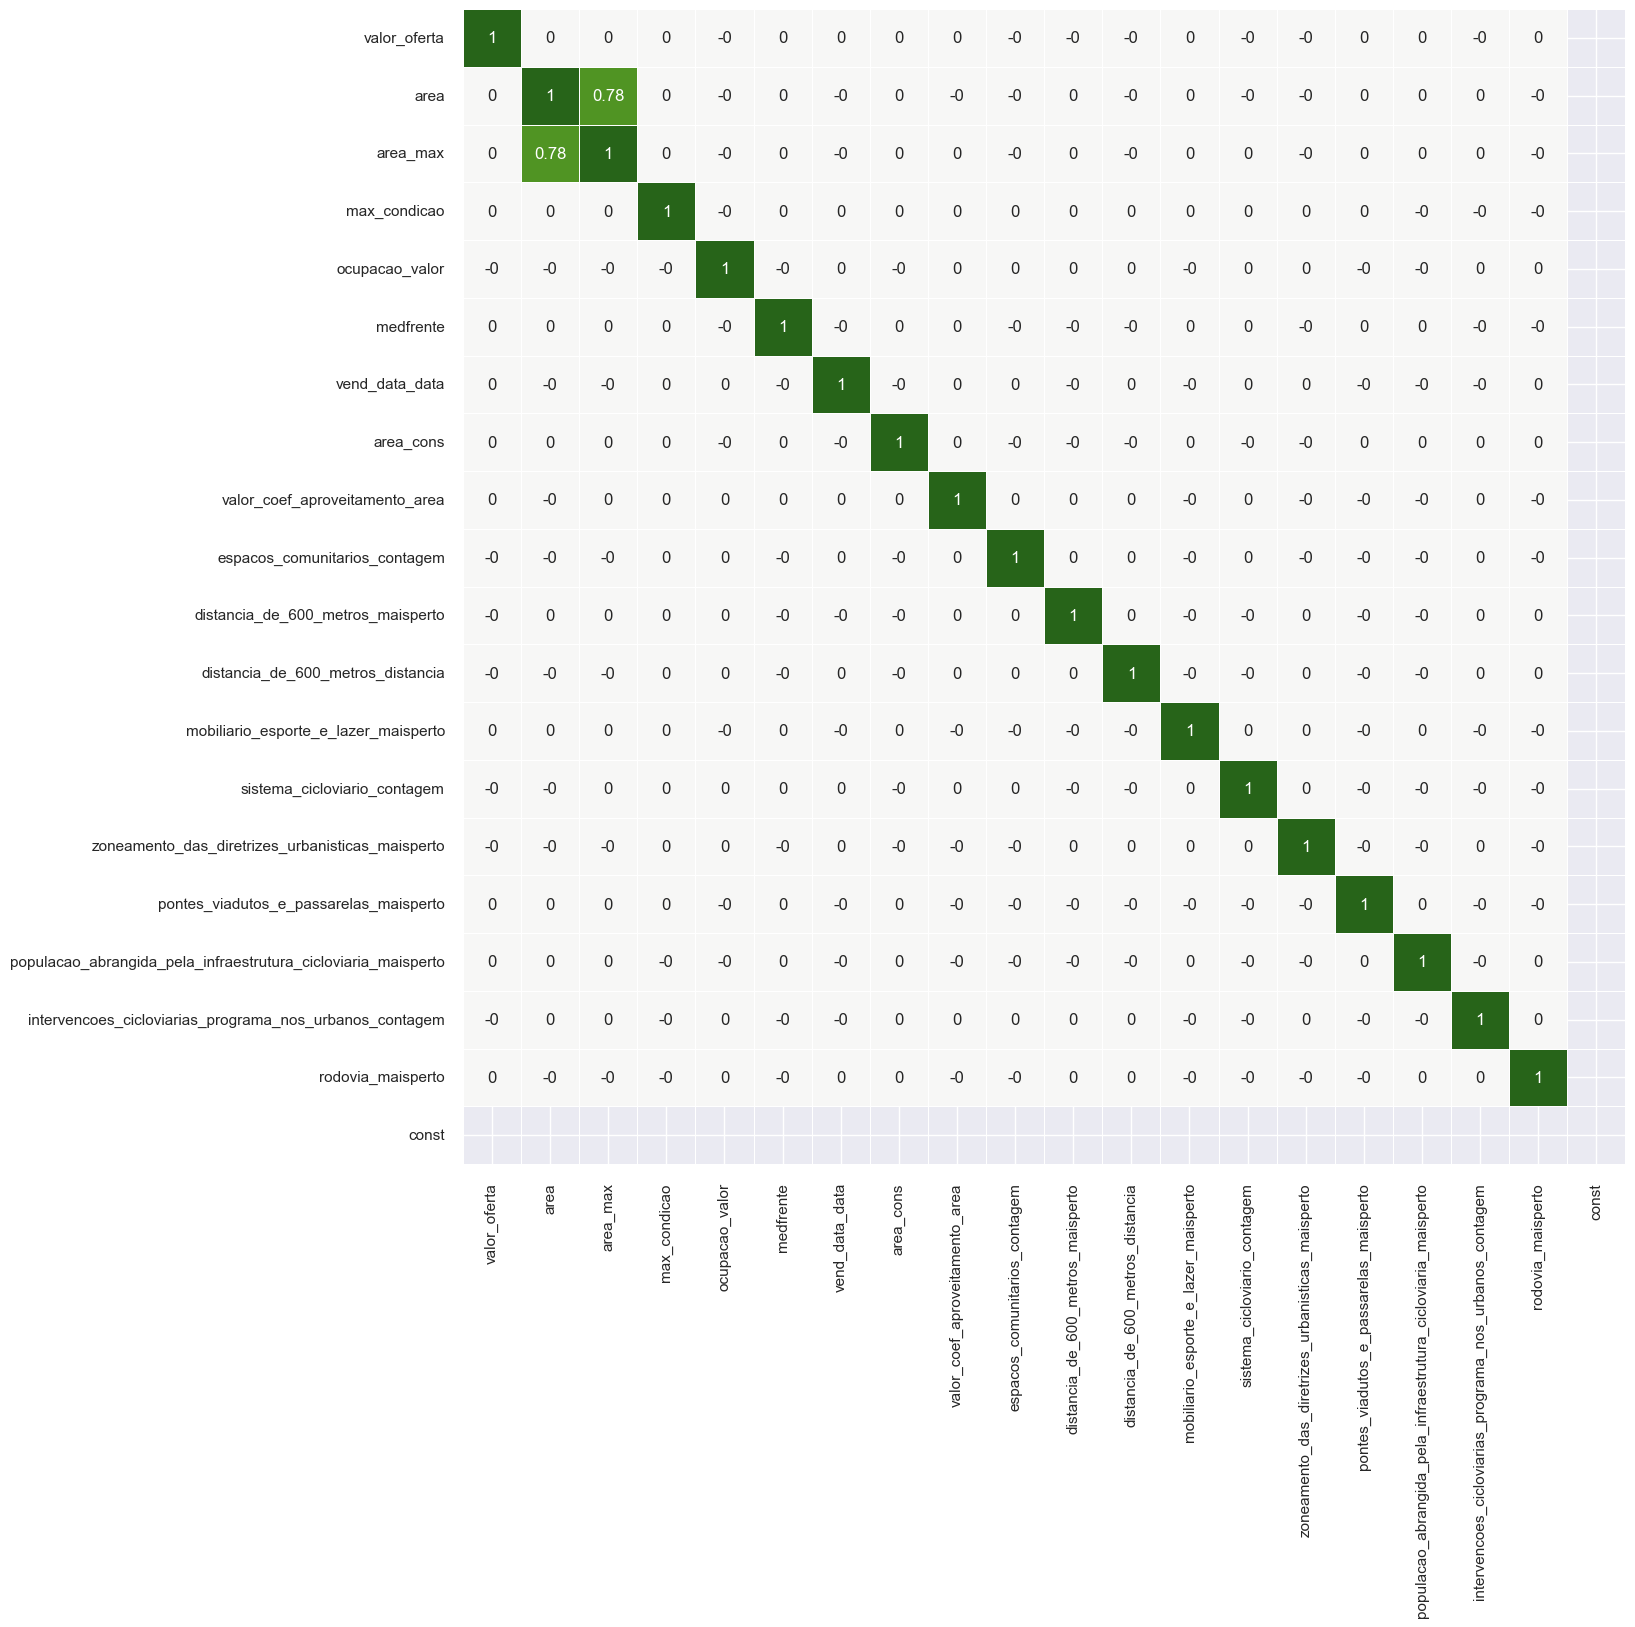

In [ ]:
# Calculate correlation matrix
corr_matrix = df.corr()

# Create a mask for correlations greater than 0.8
high_corr_mask = np.abs(corr_matrix) > 0.7

# Create a new correlation matrix where all correlations <= 0.8 are set to 0
high_corr_matrix = corr_matrix * high_corr_mask

sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(high_corr_matrix,
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="PiYG")
plt.show()

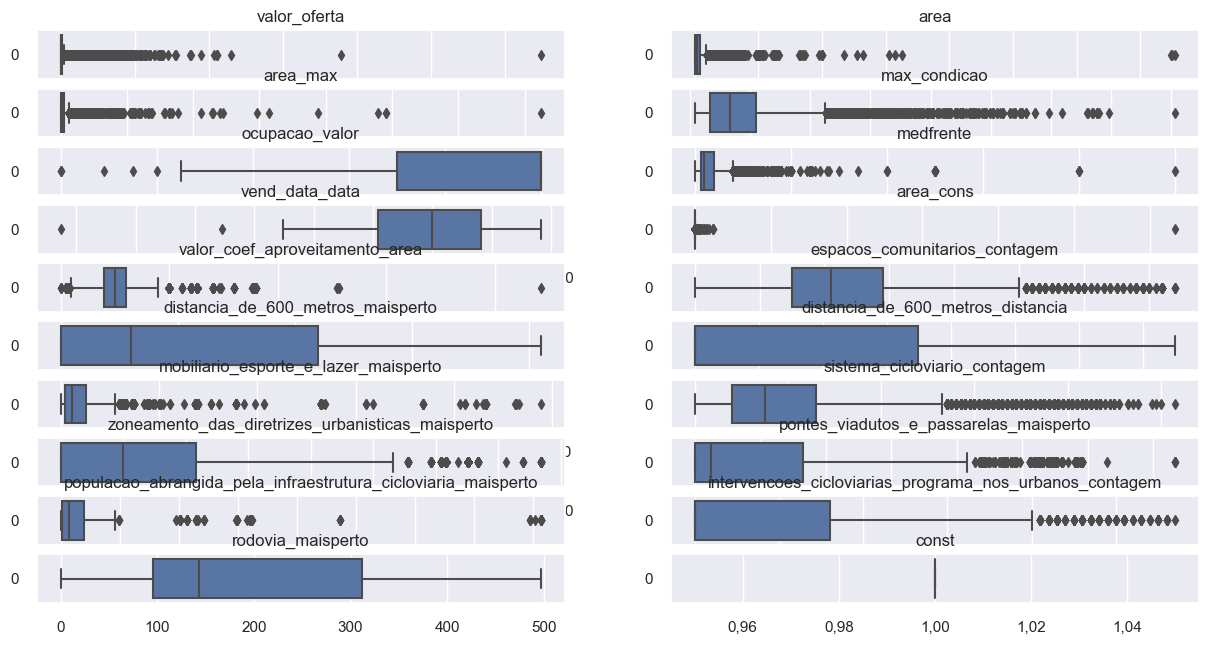

In [ ]:
count=1
plt.subplots(figsize=(15,15))
for i in df.columns:
    if df[i].dtypes  not in ['object', 'string', 'category', 'datetime64[ns]', 'geometry']:
        plt.subplot(20,2,count)
        sns.boxplot(df[i], orient='h') #[0.05, 0.95]
        #ax.set_xlabel('Three separate samples')
        #ax.set_ylabel('Observed values')
        #plt.xlabel(f'{i}')
        plt.title(f'{i}')
        #plt.ylabel('Total Bill Amount ($)')
        count+=1
plt.tight_layout()
plt.show()


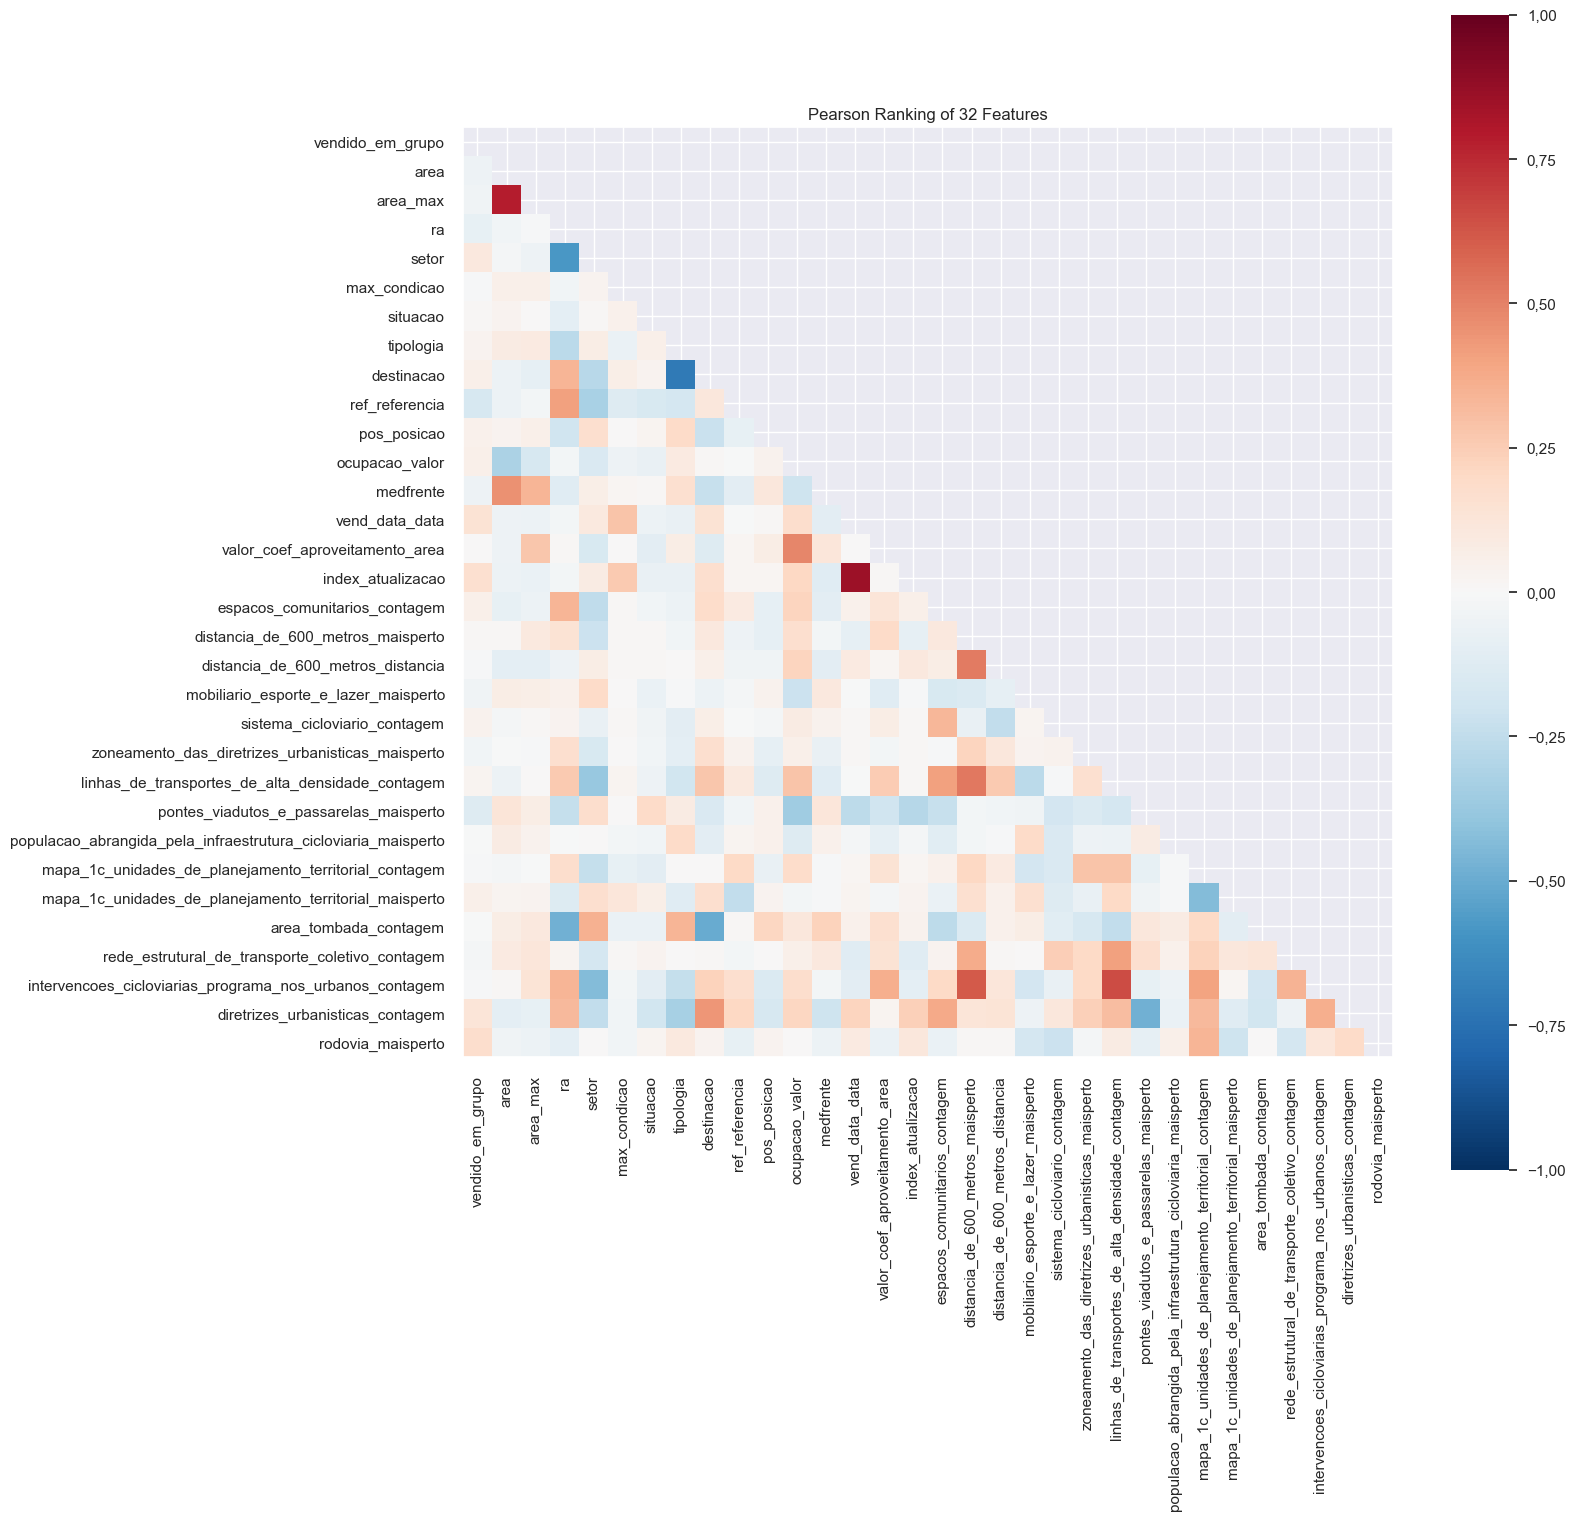

<Axes: title={'center': 'Pearson Ranking of 32 Features'}>

In [ ]:
from yellowbrick.features import Rank2D

visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(X)
visualizer.show()

# Fim do processamento [ x ]

In [ ]:
import lightgbm as lgb
from skopt import BayesSearchCV

# Definir o espaço de busca para os hiperparâmetros
param_space = {
    'num_leaves': (2, 50),  # Intervalo para num_leaves
    'learning_rate': (0.01, 0.2),  # Intervalo para learning_rate
    'n_estimators': (50, 200),  # Intervalo para n_estimators
    'max_depth': (3, 15),  # Intervalo para max_depth
    'min_child_samples': (1, 20)  # Intervalo para min_child_samples
}

# Criar uma instância do LGBMRegressor
model = lgb.LGBMRegressor()

# Criar uma instância do BayesSearchCV
opt = BayesSearchCV(
    model,
    param_space,
    n_iter=50,  # Número de iterações de busca
    cv=3,  # Número de folds para validação cruzada
    n_jobs=-1,  # Número de núcleos do processador a serem usados (-1 usa todos disponíveis)
    random_state=42
)

# Realizar a busca bayesiana para encontrar os melhores hiperparâmetros
opt.fit(X, y_3)

# Exibir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:")
print(opt.best_params_)

Melhores hiperparâmetros:
OrderedDict([('learning_rate', 0.2), ('max_depth', 3), ('min_child_samples', 20), ('n_estimators', 200), ('num_leaves', 50)])


In [ ]:
#from sklearn.linear_model import Lasso
#from yellowbrick.regressor import prediction_error
##from sklearn.svm import SVC
#from yellowbrick.model_selection import ValidationCurve
#from sklearn.model_selection import StratifiedKFold
#from sklearn.tree import DecisionTreeRegressor
#from lightgbm import LGBMRegressor
## Create the train and test data
#X_train, X_test, y_train, y_test = train_test_split(X, y_3, test_size=0.2, random_state=42)

## Instantiate the linear model and visualizer
#model = LGBMRegressor()
#visualizer = prediction_error(model, X_train, y_train, X_test, y_test)

In [ ]:
#from yellowbrick.regressor import ResidualsPlot
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
#rom sklearn.ensemble._hist_gradient_boosting.gradient_boosting  import HistGradientBoostingRegressor

#regressor_atual = HistGradientBoostingRegressor

## Create training and test sets
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y_3, test_size=0.1
#)

#visualizer = ResidualsPlot(regressor_atual())
#visualizer.fit(X_train, y_train)
#visualizer.score(X_test, y_test)
#visualizer.show()

In [ ]:
df

,vendido_em_grupo,valor_oferta,area,area_max,ra,setor,max_condicao,situacao,tipologia,destinacao,...,mapa_1c_unidades_de_planejamento_territorial_contagem,mapa_1c_unidades_de_planejamento_territorial_maisperto,area_tombada_contagem,regioes_administrativas_maisperto,rede_estrutural_de_transporte_coletivo_contagem,intervencoes_cicloviarias_programa_nos_urbanos_contagem,regulaziracao_contagem,diretrizes_urbanisticas_contagem,rodovia_maisperto,const
0,0,73850.00,250.00,500.00,Ceilƒndia,SETOR M NORTE-QUADRA RESIDENCIAL (M/NORTE-QNM),81,6 - CERCADO,60214,"60214 - UOS RO 1 - RESIDENCIAL OBRIGATàRIO, N...",...,1,6,0,0,5,12,0,0,179,1
1,1,24450.00,50.00,200.00,Ceilƒndia,SETOR P NORTE-ENTREQUADRA (P/NORTE-EQNP),35,3 - OCUPADO,60216,"60216 - UOS CSIIR 1 - COMERCIAL, PRESTA€ÇO DE ...",...,1,6,0,0,1,1,3,2,0,1
2,0,120180.00,92.40,223.61,Bras¡lia,SETOR COMERCIAL LOCAL RESIDENCIAL NORTE (SCLR/N),30,1 - VAGO,COMERCIAL/SERVI€OS,110 - COMRCIO LOCAL,...,1,2,1,14,8,0,0,0,76,1
3,0,61100.00,600.00,2400.00,Samambaia,QS-SAMAMBAIA (SAMAMBAIA),9,1 - VAGO,60218,"60218 - UOS CSIIR 3- COMERCIAL, PRESTA€ÇO DE S...",...,3,1,0,3,8,24,0,2,149,1
4,0,506600.00,8083.00,20207.50,Taguatinga,BAIRRO AGUAS CLARAS (AG/CLARAS),14,2 - OBSTRUIDO,60213,"60213 - UOS RE 3 - RESIDENCIAL EXCLUSIVO, NA C...",...,2,4,0,2,2,41,1,2,0,1
5,0,1862000.00,4401.49,14524.92,Bras¡lia,SETOR DE HAB COLETIVAS SUDOESTE (SHC/SW),18,1 - VAGO,MISTO,250 - COMERCIAL DE BENS DE SERVICO OU COLETIVO...,...,1,2,1,4,3,0,0,0,90,1
6,0,72548.00,648.00,1296.00,Taguatinga,BAIRRO AGUAS CLARAS (AG/CLARAS),8,1 - VAGO,60213,"60213 - UOS RE 3 - RESIDENCIAL EXCLUSIVO, NA C...",...,1,4,0,13,3,46,2,2,98,1
7,0,18900.00,100.00,300.00,Samambaia,QS-SAMAMBAIA (SAMAMBAIA),8,3 - OCUPADO,60219,"60219 - UOS CSIIR 1 NO - COMERCIAL, PRESTA€ÇO ...",...,1,6,0,3,4,27,1,2,0,1
8,0,147700.00,2469.97,4445.95,Taguatinga,SETOR DE MANSåES TAGUATINGA (ST/MANSåES TAG),15,1 - VAGO,60212,"60212 - UOS RE 2 - RESIDENCIAL EXCLUSIVO, NA C...",...,1,6,0,3,8,12,2,2,0,1
9,0,77100.00,240.00,960.00,Riacho Fundo,SETOR HABITACIONAL RIACHO FUNDO (RIACHO FUNDO),8,1 - VAGO,60219,"60219 - UOS CSIIR 1 NO - COMERCIAL, PRESTA€ÇO ...",...,2,4,0,2,3,0,2,2,96,1
